# Setup

In [ ]:
#instala as bibliotecas
%%capture
!pip install datasets -q

In [ ]:
#importa o dataset
from datasets import Dataset, load_dataset
dataset = load_dataset("belisards/ementas_anotadas")

In [ ]:
cols = ["text","label"]
fix_columns = {"label_tema":"label"}

test = dataset["test"].to_pandas().rename(columns=fix_columns)[cols]

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

model_name = "azmina/ia-feminista-elas-no-congresso-tema"
tokenizer = 'neuralmind/bert-base-portuguese-cased'

# Carrega o modelo fine tunado e o tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Nome dos temas para os rótulos
config = AutoConfig.from_pretrained(model_name)

if hasattr(config, "id2label"):
    class_mapping = config.id2label
else:
    print("No label mapping found in the model configuration.")
class_mapping

{0: 'economia',
 1: 'genero',
 2: 'dignidade sexual',
 3: 'violencia contra a mulher',
 4: 'politica',
 5: 'direitos sexuais e reprodutivos',
 6: 'direitos sociais',
 7: 'maternidade',
 8: 'feminicidio'}

In [ ]:
#set o cuda para a CPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm(

In [ ]:
#inferências do modelo nos dados de teste
import torch

def inference(string):
    tokens = tokenizer(string, truncation=True, max_length=512, return_tensors="pt")
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)

    predicted_index = outputs.logits.argmax(dim=-1).item()
    predicted_class = class_mapping[predicted_index]
    all_proba = outputs.logits.softmax(dim=-1).tolist()[0]
    pred_proba = all_proba[predicted_index]

    return predicted_class, all_proba, pred_proba


test["pred_label"], test["all_proba"], test["pred_proba"] = zip(*test["text"].apply(lambda x: inference(x)))

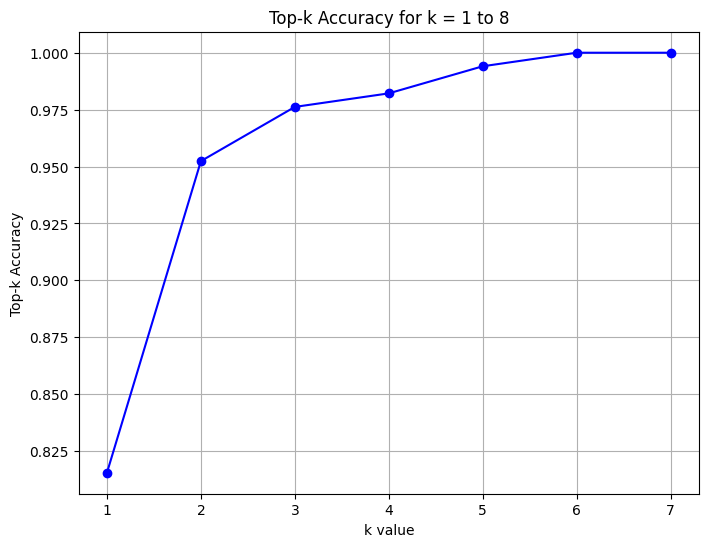

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
unique_labels = list(class_mapping.values())

# Mapeia o nome das labels ecom os index
label_to_index = {label: idx for idx, label in enumerate(class_mapping.values())}

test['label_indices'] = test['label'].map(label_to_index)
top_k_accuracies = {}
top_k = len(unique_labels) - 1

for k in range(1, top_k):
    top_k_acc = top_k_accuracy_score(test['label_indices'].tolist(), test['all_proba'].tolist(), k=k)
    top_k_accuracies[k] = top_k_acc

# Plot dos resultados
plt.figure(figsize=(8, 6))
plt.plot(list(top_k_accuracies.keys()), list(top_k_accuracies.values()), marker='o', linestyle='-', color='b')
plt.title(f'Top-k Accuracy for k = 1 to {top_k}')
plt.xlabel('k value')
plt.ylabel('Top-k Accuracy')
plt.xticks(range(1, top_k))  # Ensure x-ticks are set for each k
plt.grid(True)
plt.show()


In [ ]:
#Métricas da avaliação do modelo
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, \
                            classification_report, f1_score, precision_recall_fscore_support


print(classification_report(test['label'].tolist(), test["pred_label"].to_list()))


                                 precision    recall  f1-score   support

               dignidade sexual       0.94      0.88      0.91        17
direitos sexuais e reprodutivos       0.89      0.84      0.86        19
               direitos sociais       0.61      0.58      0.59        19
                       economia       0.78      0.50      0.61        14
                    feminicidio       0.67      0.80      0.73         5
                         genero       0.81      1.00      0.90        13
                    maternidade       0.70      0.74      0.72        19
                       politica       1.00      0.88      0.93         8
      violencia contra a mulher       0.86      0.93      0.89        54

                       accuracy                           0.82       168
                      macro avg       0.81      0.79      0.79       168
                   weighted avg       0.82      0.82      0.81       168



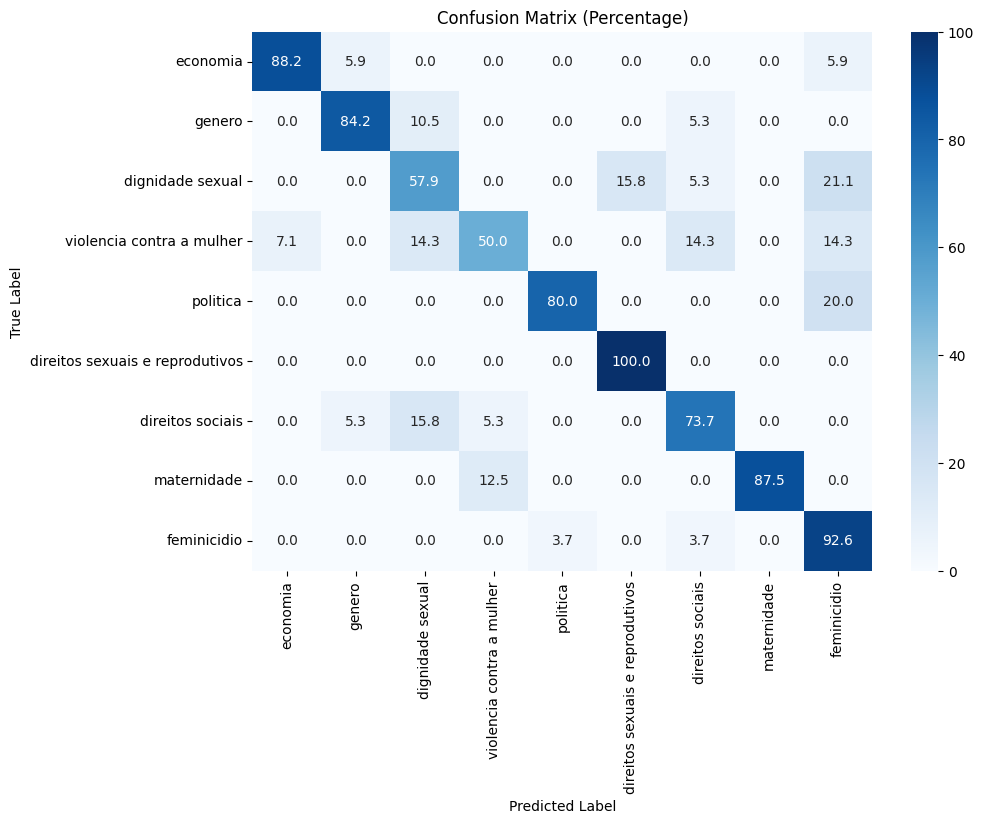

In [ ]:
#Matriz de confusão
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


cm = confusion_matrix(test['label'].tolist(), test["pred_label"].to_list())
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.round(cm_percent, 1)

#Plot da matriz
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()


In [ ]:
#Curva ROC para cada um dos temas
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import LabelBinarizer


y_true = test['label'].tolist()
y_pred = test["pred_label"].to_list()


lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)


class_mapping = {index: class_name for index, class_name in enumerate(lb.classes_)}


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fig = go.Figure()

for i in range(n_classes):

    fpr_interp = np.linspace(0, 1, 100)
    tpr_interp = np.interp(fpr_interp, fpr[i], tpr[i])
    fig.add_trace(go.Scatter(
        x=fpr_interp,
        y=tpr_interp,
        mode='lines',
        name=f'{class_mapping[i]} (area = {roc_auc[i]:0.2f})'
    ))


fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='navy', dash='dash'),
    showlegend=False
))


fig.update_layout(
    title='Receiver Operating Characteristic (ROC)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1.05]),
    legend=dict(x=0.8, y=0.2),
    width=800,
    height=600
)

fig.show()


In [ ]:
#Calibration Curve para cada um dos temas
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import LabelBinarizer

y_true = test['label'].tolist()
y_pred = test["pred_label"].to_list()

#
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)


class_mapping = {index: class_name for index, class_name in enumerate(lb.classes_)}


prob_true = dict()
prob_pred = dict()
n_classes = len(lb.classes_)

for i in range(n_classes):
    prob_true[i], prob_pred[i] = calibration_curve(y_true_bin[:, i], y_pred_bin[:, i], n_bins=10)


fig = go.Figure()

for i in range(n_classes):
    fig.add_trace(go.Scatter(
        x=prob_pred[i],
        y=prob_true[i],
        mode='lines+markers',
        name=class_mapping[i]
    ))


fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='navy', dash='dash'),
    showlegend=False
))


fig.update_layout(
    title='Calibration Curve',
    xaxis_title='Mean Predicted Probability',
    yaxis_title='Fraction of Positives',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1.05]),
    legend=dict(x=0.8, y=0.2),
    width=800,
    height=600
)

fig.show()
